In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sbi.analysis.plot import  pairplot
import seaborn as sns
sns.set()

In [3]:
df = pd.read_csv('../data/beta_event_amplitude.csv',index_col=0)
label_names = ['L2 prox gbar', 'L5 prox gbar', 'L2 dist gbar', 'L5 dist gbar', 'Prox variance', 'Dist variance',
               'Prox mean time', 'Dist mean time', 'Amplitude']
df.columns = label_names

data_dict = {'gbar_evprox_1_L2Pyr_ampa': (1e-10, 1e-1), 
               'gbar_evprox_1_L5Pyr_ampa': (1e-10, 1e-1), 
               'gbar_evdist_1_L2Pyr_ampa': (1e-10, 1e-1), 
               'gbar_evdist_1_L5Pyr_ampa': (1e-10, 1e-1),
               'sigma_t_evprox_1': (1, 100),
               'sigma_t_evdist_1': (1, 100),
               't_evprox_1': (200, 300),
               't_evdist_1': (200, 300),
               'amplitude': (-10000, 0)}

In [4]:
# Simple EDA
df.describe()

,L2 prox gbar,L5 prox gbar,L2 dist gbar,L5 dist gbar,Prox variance,Dist variance,Prox mean time,Dist mean time,Amplitude
count,102400.000000,102400.000000,102400.000000,102400.000000,102400.000000,102400.000000,102400.000000,102400.000000,102400.000000
mean,0.018298,0.047762,0.027505,0.066661,8.675723,7.627285,237.362732,269.966538,-3456.397190
std,0.010950,0.016171,0.018898,0.022484,4.422958,4.232500,7.825738,3.636607,1029.907405
min,0.000006,0.000067,0.000064,0.000011,1.001329,1.000024,200.354797,221.657013,-6367.999023
25%,0.011867,0.035077,0.012468,0.052093,6.176690,4.524401,233.111916,267.737389,-4058.037537
50%,0.015792,0.046474,0.022661,0.074476,8.586326,6.958612,236.809807,269.724854,-3467.989990
75%,0.021148,0.058100,0.037907,0.083587,10.718471,9.968032,240.711460,271.978157,-2788.046143
max,0.099811,0.099957,0.099999,0.099997,99.743340,75.734001,299.418030,297.730255,-538.686218


In [5]:
dpl = np.load('../data/dpl_sim_fitted_prior_1.npy')
# Mess with indices to find generally "normal" waveoforms (one dominant negative peak)
large_idx = np.argsort(np.abs(dpl.min(axis=1)))[-100:-90]
small_idx = np.argsort(np.abs(dpl.min(axis=1)))[100:110]

large_x = dpl[large_idx, :]
small_x = dpl[small_idx, :]


No handles with labels found to put in legend.


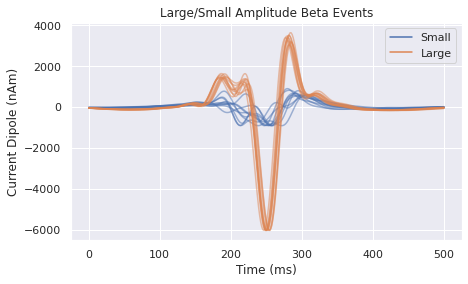

In [6]:
# Large/Small beta event
plt.figure(figsize=(7,4))
x_times = np.tile(np.linspace(0, 500, small_x.shape[1]), 10).reshape(10,-1)
plt.plot(x_times.T, small_x.T, color='C0', alpha=0.5)
plt.plot(x_times.T, large_x.T, color='C1', alpha=0.5)
plt.ylabel('Current Dipole (nAm)')
plt.xlabel('Time (ms)')
plt.title('Large/Small Amplitude Beta Events')
plt.legend()

# Fake lines for legend
plt.plot([0,0], [0,0], color='C0', alpha=1, label='Small')
plt.plot([0,0], [0,0], color='C1', alpha=1, label='Large')
plt.legend()
plt.savefig('../figures/beta_event_amplitude.png')

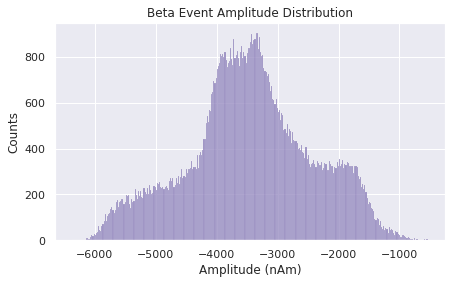

In [7]:
# Beta Event Histogram
plt.figure(figsize=(7,4))
sns.histplot(data=df, x='Amplitude', bins=int(np.sqrt(df.shape[0])), color='C4')
plt.xlabel('Amplitude (nAm)')
plt.ylabel('Counts')
plt.title('Beta Event Amplitude Distribution')
plt.savefig('../figures/beta_event_amplitude_histogram.png')

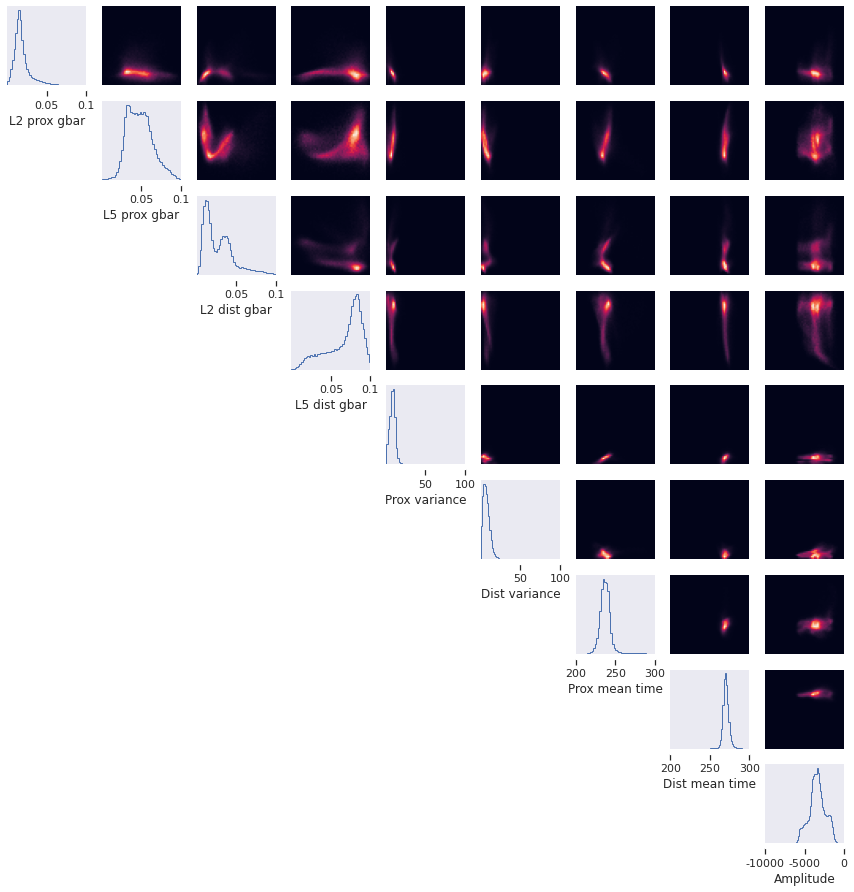

In [8]:
sns.set_style({'axes.grid' : False})
ax = pairplot(df.to_numpy(), figsize=(15,15), labels=label_names, limits=list(data_dict.values()))
sns.set_style({'axes.grid' : True})
plt.savefig('../figures/marginal_distribution.png')

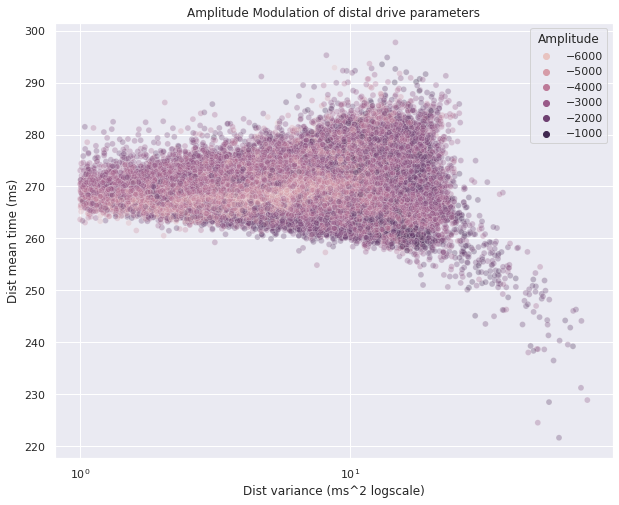

In [9]:
plt.figure(figsize=(10,8))
splot = sns.scatterplot(data=df, x ='Dist variance', y='Dist mean time', hue='Amplitude', alpha=0.3)
splot.set(xscale="log")
plt.xlabel('Dist variance (ms^2 logscale)')
plt.ylabel('Dist mean time (ms)')
plt.title('Amplitude Modulation of distal drive parameters')
plt.savefig('../figures/distal_param_amplitude.png')

Text(0.5, 1.0, 'Amplitude Modulation')

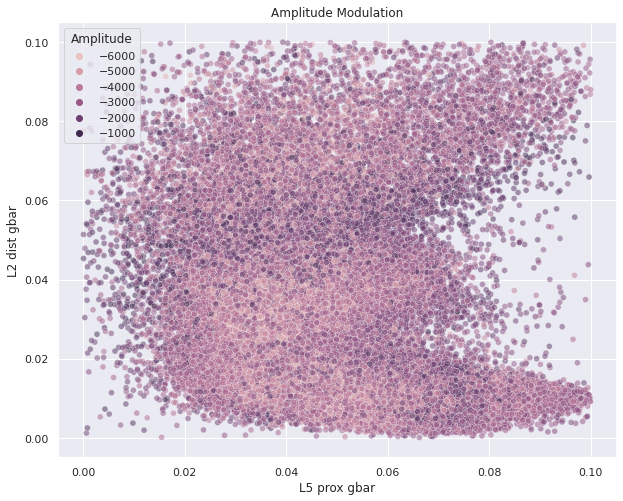

In [10]:
plt.figure(figsize=(10,8))
splot = sns.scatterplot(data=df, x =label_names[1], y=label_names[2], hue='Amplitude', alpha=0.5)
plt.title('Amplitude Modulation')


In [34]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Same pipeline applies to both questions
std_ftrs = np.array(label_names)
std_ftrs = std_ftrs[std_ftrs != 'Amplitude']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])


In [35]:
# Preprocessing and splitting
from sklearn.model_selection import KFold
X = df.iloc[:, df.columns != 'Amplitude']
y = df.iloc[:, df.columns == 'Amplitude'].values

kfold = KFold(n_splits=5)

for train_index, test_index in kfold.split(X, y):
    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    y_train = y[train_index]
    y_test = y[test_index]


    # Transform
    X_train_prep = clf.fit_transform(X_train)
    X_test_prep = clf.transform(X_test)

    print(X_train_prep.shape, X_test_prep.shape)
    print(y_train.shape, y_test.shape)
    print(' ')

    # Model training/prediction here...



(81920, 8) (20480, 8)
(81920, 1) (20480, 1)
 
(81920, 8) (20480, 8)
(81920, 1) (20480, 1)
 
(81920, 8) (20480, 8)
(81920, 1) (20480, 1)
 
(81920, 8) (20480, 8)
(81920, 1) (20480, 1)
 
(81920, 8) (20480, 8)
(81920, 1) (20480, 1)
 
